In [1]:
import cv2
import numpy as np
import random
import time
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 12

Batch 1: 255671 features left for use
Batch 2: 180628 features left for use
Batch 3: 129079 features left for use
Batch 4: 87395 features left for use
Batch 5: 62253 features left for use
Batch 6: 43235 features left for use
Batch 7: 28839 features left for use
Batch 8: 18570 features left for use
Batch 9: 11668 features left for use
Batch 10: 6407 features left for use
Batch 11: 3303 features left for use
Batch 12: 1198 features left for use
Batch 13: 178 features left for use
Processing time: 60.900000 min


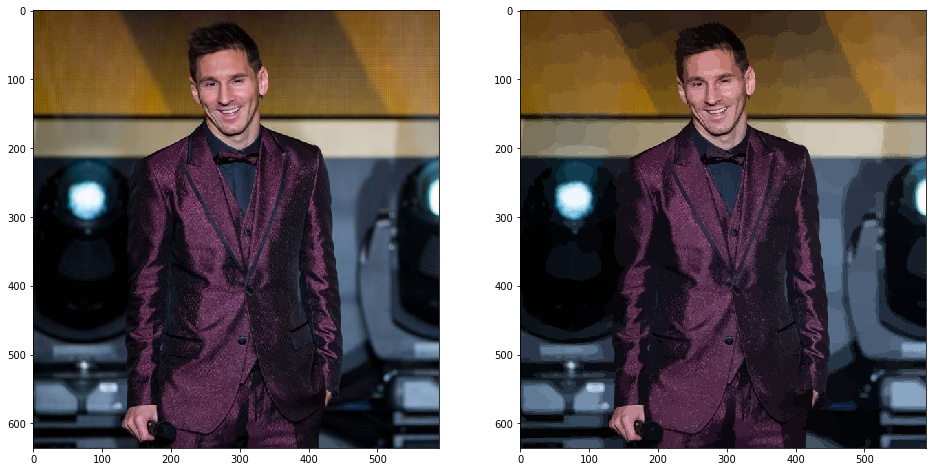

In [2]:
image = cv2.imread("../resources/messi2.jpg")

rows, cols = image.shape[:2]
out = np.zeros_like(image)
feature_space = np.zeros(shape=(rows * cols, 5))  # r, g, b, row, col

threshold_dist = 25
flag = True
mean_feature = np.zeros(shape=(1, 5))

idx = 0
for r in range(rows):
    for c in range(cols):
        feature_space[idx][:3] = image[r][c]
        feature_space[idx][3:] = r, c
        idx += 1

def eucl_dist(x1, x2): return np.sqrt(np.sum((x1 - x2) ** 2))

start = time.time()
counter = 1
while len(feature_space):
    if flag: mean_feature = random.choice(feature_space)
        
    below_thresh = []
    for i, feature in enumerate(feature_space):
        dist = eucl_dist(feature, mean_feature)
        if dist < threshold_dist: below_thresh.append((i, feature))
    # print("Done finding below thresh for %d iteration" % counter)
        
    new_mean = np.zeros(shape=(1, 5))
    for i, feature in below_thresh: new_mean += feature
    
    if below_thresh: new_mean /= len(below_thresh)
    else: raise Exception("Divide by zero encountered, exiting...")
    # print("Done finding new mean for %d iteration" % counter)
    
    dist = eucl_dist(new_mean, mean_feature)
    if dist < 2.0:
        for i, feature in below_thresh:
            out[int(feature[3])][int(feature[4])] = new_mean[0][:3]
            feature_space[i] = -1
            
        flag = True
        
        new_feature_space = np.zeros_like(feature_space)
        idx = 0
        for feature in feature_space:
            if feature[0] != -1:
                new_feature_space[idx] = feature
                idx += 1
        feature_space = new_feature_space[:idx]
    else:
        flag = False
        mean_feature = new_mean
    
    if counter % 500 == 0: print("Batch %d: %d features left for use" % (counter // 500, len(feature_space)))
    counter += 1

end = time.time()
time_taken = round(end - start) / 60
print("Processing time: %f min" % time_taken)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

plt.show()

[Tue Jan 23 18:44:54 2018] Applying mean shift...
[Tue Jan 23 18:49:35 2018] Finished applying mean shift
[Tue Jan 23 18:49:35 2018] Regrouping means...
[Tue Jan 23 18:49:35 2018] Finished regrouping
[Tue Jan 23 18:49:35 2018] Segmenting image...
[Tue Jan 23 19:24:00 2018] Finished segmentation
Processing time: 39.100000 min


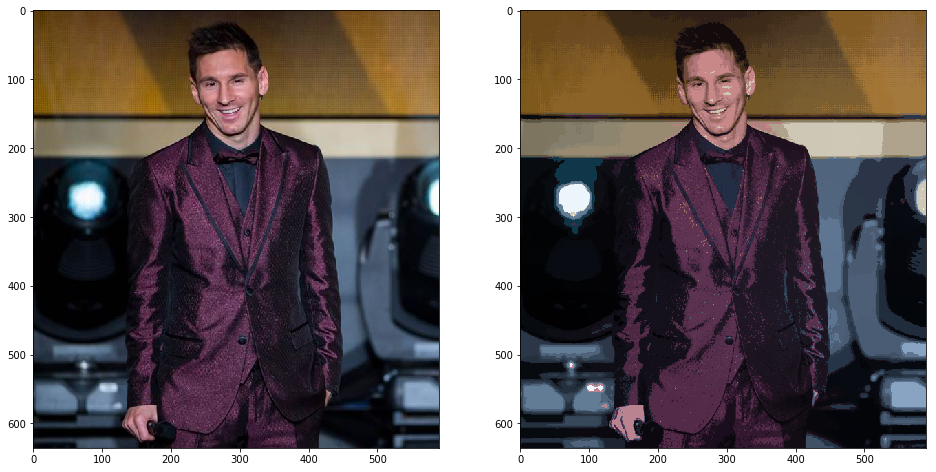

In [3]:
# better and faster
def gaussian_mean(kernel, var, bandwidth=30):
    weights = np.exp(-np.linalg.norm((kernel - var) / bandwidth, axis=1))
    return np.array(np.sum(weights[:, None] * kernel, axis=0) / np.sum(weights), dtype=np.int64)

mean_dist = np.array([[1000.0 for c in range(cols)] for r in range(rows)])
labels = np.array([[-1 for c in range(cols)] for r in range(rows)])

def apply_mean_shift(image, rows, cols, min_win_size=40, iters=20, threshold_dist=30):
    print("[%s] Applying mean shift..." % time.ctime())
    means = []
    for r in range(0, rows, min_win_size):
        for c in range(0, cols, min_win_size):
            feature = np.append(image[r][c], [r, c])
            
            for _ in range(iters):
                x, y = feature[3:]
                top, left = max(0, x - min_win_size), max(0, y - min_win_size)
                bottom, right = min(top + min_win_size * 2, rows), min(left + min_win_size * 2, cols)
                
                kernel = []; app = kernel.append
                for rr in range(top, bottom):
                    for cc in range(left, right):
                        # Distance = sqrt(Dc^2 + (Ds / S)^2 * m^2)
                        Dc = eucl_dist(image[rr][cc], feature[:3])
                        Ds = eucl_dist(np.array([rr, cc]), feature[3:]) / 5
                        D = eucl_dist(np.array([Dc, Ds]), 0)
                        if D < threshold_dist: app(np.append(image[rr][cc], [rr, cc]))
                
                kernel = np.array(kernel)
                mean = gaussian_mean(kernel, feature)
                
                Dc = eucl_dist(mean[:3], feature[:3])
                Ds = eucl_dist(mean[3:], feature[3:]) / 5
                D = eucl_dist(np.array([Dc, Ds]), 0)
                if D <= 1.0: break  # convergence
                
                feature = mean
            means.append(np.asarray(feature, dtype=np.float32))
    print("[%s] Finished applying mean shift" % time.ctime())
    return np.array(means)

def cluster(means, threshold_dist=30):
    print("[%s] Regrouping means..." % time.ctime())
    l = len(means)
    flags = [True] * l
    for i in range(l):
        if flags[i]:
            w = 1.0
            for j in range(i + 1, l):
                Dc = eucl_dist(means[i][:3], means[j][:3])
                Ds = 5 * eucl_dist(means[i][3:], means[j][3:])
                D = eucl_dist(np.array([Dc, Ds]), 0)
                if D < threshold_dist:
                    means[i] += means[j]
                    w += 1.0
                    flags[j] = False
            means[i] /= w
    
    print("[%s] Finished regrouping" % time.ctime())
    return np.array([means[i] for i in range(l) if flags[i]])

def segment(image, rows, cols, conv_means):
    print("[%s] Segmenting image..." % time.ctime())
    segmented = np.zeros_like(image)

    for r in range(rows):
        for c in range(cols):
            for i, mean in enumerate(conv_means):
                Dc = eucl_dist(image[r][c], mean[:3])
                Ds = eucl_dist(np.array([r, c]), mean[3:]) / 5
                D = eucl_dist(np.array([Dc, Ds]), 0)
                if D < mean_dist[r][c]:
                    mean_dist[r][c] = D
                    labels[r][c] = i
            segmented[r][c] = conv_means[labels[r][c]][:3]
    
    print("[%s] Finished segmentation" % time.ctime())
    return segmented

start = time.time()

means = apply_mean_shift(image, rows, cols)
conv_means = cluster(means)
out = segment(image, rows, cols, conv_means)

end = time.time()
time_taken = round(end - start) / 60
print("Processing time: %f min" % time_taken)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

plt.show()